In [1]:
import torch
import torch.nn as nn
from datetime import datetime
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
from model import AutoEncoder
from tqdm import tqdm 
import numpy as np

In [2]:
save_path = 'model_128.pth'

In [3]:
if torch.cuda.is_available():
    print("CUDA is available. Training on GPU.")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Exiting...")
    exit()

CUDA is available. Training on GPU.
Number of GPUs available: 1
GPU name: NVIDIA RTX A5000


In [4]:
# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据预处理
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),  # 调整图片大小
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # 将图片转换为Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #[-1, 1]
])

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # 调整图片大小
    transforms.ToTensor(),  # 将图片转换为Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #[-1, 1]
])

# 数据集路径
base_path = '/Group16T/raw_data/covid_cxr'

# 加载数据集
train_dataset = datasets.ImageFolder(root=f'{base_path}/train', transform=transform_train)
val_dataset = datasets.ImageFolder(root=f'{base_path}/val', transform=transform)
test_dataset = datasets.ImageFolder(root=f'{base_path}/test', transform=transform)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, pin_memory=True, num_workers=16)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, pin_memory=True, num_workers=16)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, pin_memory=True, num_workers=16)

print(f"train_dataset: {len(train_dataset)}, val_dataset: {len(val_dataset)}, test_dataset: {len(test_dataset)}")

# 初始化模型
autoencoder = AutoEncoder().to(device)

# 损失函数和优化器
loss_func = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)


train_dataset: 67863, val_dataset: 8473, test_dataset: 8482


In [5]:
#Load pretrained model
autoencoder.load_state_dict(torch.load(save_path))

<All keys matched successfully>

## Block below is used to train from scratch

In [7]:
num_epochs = 5

autoencoder.train() #Set model to training mode
for epoch in range(num_epochs): 
    epoch_start_time = datetime.now()  # 记录epoch开始的时间 

    train_loss = 0
    # 使用tqdm包装数据加载器，以显示进度条
    train_loader_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
    for data in train_loader_pbar:
        img, _ = data  # img is in shape (batch_size, 3, 64, 64) / I don't need label and patient_id in training
        img_flat = img.view(img.size(0), -1)  # Flatten img for the model input
        img_flat = Variable(img_flat).to(device)
        # ===================forward=====================
        output = autoencoder(img_flat)
        output = output.view(img.size(0), 3, 256, 256)  # Reshape output to original shape for loss calculation
        loss = loss_func(output, img.to(device))  # Use original shape img for loss calculation
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================       
    train_loader_pbar.set_description(
                f'Epoch {epoch+1}/{num_epochs} '
                f'[Train] Loss: {train_loss/len(train_loader_pbar):.4f}')
    

#Save model
torch.save(autoencoder.state_dict(), save_path)

   

Epoch 1/5 [Train]:   0%|          | 0/266 [00:00<?, ?it/s]

In [6]:
autoencoder.eval()
val_results = {
    "positive": [],
    "negative": []
}

loss_func = nn.MSELoss(reduction='none')
# 使用tqdm包装数据加载器，以显示进度条
val_loader_pbar = tqdm(val_loader, desc=f'[Val] Single Epoch Validation')
with torch.no_grad():
    for data in val_loader_pbar:
        img, label = data  # img is in shape (batch_size, 3, 64, 64)
        img_flat = img.view(img.size(0), -1)  # Flatten img for the model input
        img_flat = Variable(img_flat).to(device)
        # ===================forward=====================
        output = autoencoder(img_flat)
        output = output.view(img.size(0), 3, 128, 128)  # Reshape output to original shape for loss calculation
        loss = loss_func(output, img.to(device))  # Use original shape img for loss calculation
        loss_per_sample = loss.mean(dim=[1, 2, 3])  # 平均每個樣本的損失，假設是圖像數據

        for i in range(len(label)):
            sample_loss = loss_per_sample[i].item()
            if label[i] == 0:
                val_results["negative"].append(sample_loss)
            else:
                val_results["positive"].append(sample_loss)


[Val] Single Epoch Validation: 100%|██████████| 34/34 [00:10<00:00,  3.31it/s]


In [7]:
print(val_results)
negative_data = np.array(val_results["negative"])
print(negative_data)

{'positive': [0.023311978206038475, 0.026324382051825523, 0.043958842754364014, 0.03351869061589241, 0.04353897273540497, 0.014469305984675884, 0.034204550087451935, 0.019447309896349907, 0.03483380004763603, 0.018315885215997696, 0.0322096049785614, 0.26070892810821533, 0.017756616696715355, 0.02400352619588375, 0.01793629303574562, 0.024384405463933945, 0.029183318838477135, 0.02480281889438629, 0.026803119108080864, 0.01193965133279562, 0.02406957745552063, 0.032438334077596664, 0.0479714572429657, 0.03277222812175751, 0.06254038214683533, 0.01522904448211193, 0.048653315752744675, 0.023467320948839188, 0.03927963227033615, 0.01778995245695114, 0.030651818960905075, 0.05565797537565231, 0.07315978407859802, 0.027032680809497833, 0.05115581303834915, 0.11862514913082123, 0.191473126411438, 0.03972732648253441, 0.05471532791852951, 0.011703377589583397, 0.03547115623950958, 0.041492901742458344, 0.036562032997608185, 0.03984919935464859, 0.05097758769989014, 0.017703024670481682, 0.02

In [8]:
# #Calculate 95 precentile of negative data
# threshold = np.percentile(negative_data, 50)
# print(f"Threshold: {threshold}")
def thresholding(x, threshold):
    if x > threshold:
        return 1
    else:
        return 0
    

In [9]:
# 初始化列表以存储真实标签和模型预测概率
y_true = []
test_loss = []
y_pred = []


autoencoder.eval()
# 使用tqdm包装数据加载器，以显示进度条
test_loader_pbar = tqdm(test_loader, desc=f'[Test]')
with torch.no_grad():
    for data in test_loader_pbar:
        img, label = data  # img is in shape (batch_size, 3, 64, 64)
        img_flat = img.view(img.size(0), -1)  # Flatten img for the model input
        img_flat = Variable(img_flat).to(device)
        # ===================forward=====================
        output = autoencoder(img_flat)
        output = output.view(img.size(0), 3, 128, 128)  # Reshape output to original shape for loss calculation
        loss = loss_func(output, img.to(device))  # Use original shape img for loss calculation
        loss_per_sample = loss.mean(dim=[1, 2, 3])  # 平均每個樣本的損失，假設是圖像數據
        
        # Save the results
        for i in range(len(label)):
            sample_loss = loss_per_sample[i].item()
            y_true.append(label[i].item())
            test_loss.append(sample_loss)

[Test]: 100%|██████████| 34/34 [00:11<00:00,  3.06it/s]


In [10]:
roc_data = []

#Calculate ROC

for precentile_num in range(0, 101):
    threshold = np.percentile(negative_data, precentile_num)
    y_pred = [thresholding(x, threshold) for x in test_loss]
    tp = sum([1 for i in range(len(y_pred)) if y_pred[i] == 1 and y_true[i] == 1])
    tn = sum([1 for i in range(len(y_pred)) if y_pred[i] == 0 and y_true[i] == 0])
    fp = sum([1 for i in range(len(y_pred)) if y_pred[i] == 1 and y_true[i] == 0])
    fn = sum([1 for i in range(len(y_pred)) if y_pred[i] == 0 and y_true[i] == 1])
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    roc_data.append((tpr, fpr))

In [ ]:
roc_data

AUC: 0.5863675916949335


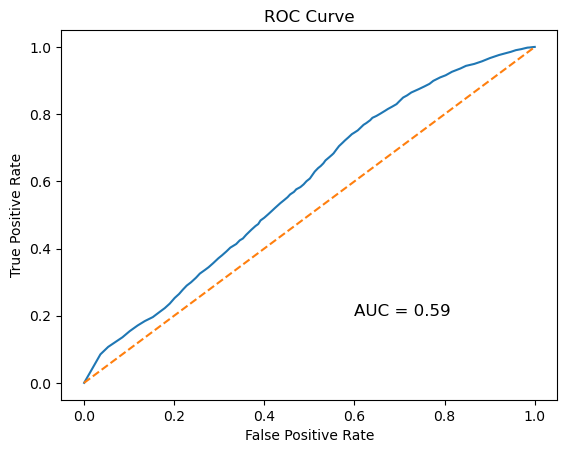

In [11]:
x = [i[1] for i in roc_data]
y = [i[0] for i in roc_data]

# Sort the roc_data based on FPR (x values)
sorted_roc_data = sorted(zip(x, y))

# Recalculate x and y after sorting
x_sorted = [i[0] for i in sorted_roc_data]
y_sorted = [i[1] for i in sorted_roc_data]

# Calculate AUC using the trapezoidal rule
auc = 0
for i in range(1, len(x_sorted)):
    auc += (y_sorted[i] + y_sorted[i-1]) * (x_sorted[i] - x_sorted[i-1]) / 2

print(f"AUC: {auc}")

plt.plot(x, y)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.text(0.6, 0.2, 'AUC = %0.2f' % auc, fontsize=12)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.savefig('roc_curve.png')
plt.show()

In [39]:
print(y_true)
print(y_pred)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [12]:
# 将列表转换为numpy数组以便进行向量化计算
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 计算TP, TN, FP, FN
TP = np.sum((y_pred == 1) & (y_true == 1))
TN = np.sum((y_pred == 0) & (y_true == 0))
FP = np.sum((y_pred == 1) & (y_true == 0))
FN = np.sum((y_pred == 0) & (y_true == 1))


# 基于TP, TN, FP, FN计算准确率、精确率、召回率（敏感性）、特异性
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0


print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Specificity: {specificity:.4f}")

Accuracy: 0.4999
Precision: 0.3333
Recall: 0.0002
Specificity: 0.9995
